In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import seaborn as sns
import warnings
from scipy.stats import entropy
from sklearn.cluster import DBSCAN

warnings.filterwarnings("ignore")
import os
import glob

matplotlib.rcParams['figure.dpi'] = 300


# Compute timeseries statistics and plot for individual patients

In [2]:
dir_ = "/home/reinhold/Daten/Paper_Datasets_Nov2022"
filenames = [r'OpenAPS complete_patient_statistics.xlsx',
    r'OPENonOH complete_patient_statistics.xlsx'] # Specify the file path

df_all_stat = {}
df_all_stat["OpenAPS"] = pd.read_excel(os.path.join(dir_, filenames[0]))  # all columns
df_all_stat["OPENonOH"] = pd.read_excel(os.path.join(dir_, filenames[1]))
print(len(df_all_stat["OPENonOH"].loc[df_all_stat["OPENonOH"]["id"].isna()]), df_all_stat["OPENonOH"].loc[df_all_stat["OPENonOH"]["id"].isna()])
df_all_stat["OpenAPS"]["id"] = df_all_stat["OpenAPS"]["id"].astype(int)
df_all_stat["OPENonOH"]["id"] = df_all_stat["OPENonOH"]["id"].astype(int)
print(len(df_all_stat["OPENonOH"].columns), df_all_stat["OPENonOH"].columns)


0 Empty DataFrame
Columns: [id, age, gender, height, weight, country, year, month, gender_int, is_child, interdaysd, interdaycv, bg_roc_stds, TOR<70, TIR, TOR>180, POR, J_index, LGBI, HBGI, GMI, count, mean, std, min, 0.25, 0.5, 0.75, max]
Index: []

[0 rows x 29 columns]
29 Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'gender_int',    'is_child',  'interdaysd',  'interdaycv',
       'bg_roc_stds',      'TOR<70',         'TIR',     'TOR>180',
               'POR',     'J_index',        'LGBI',        'HBGI',
               'GMI',       'count',        'mean',         'std',
               'min',          0.25,           0.5,          0.75,
               'max'],
      dtype='object')


In [3]:
root_dir = "/home/reinhold/Daten/dana_processing/"
sub_dir =['OpenAPS_NS_Data', 'OpenAPS_AAPS_Uploader_Data', 'OPENonOH_NS_Data', 'OPENonOH_AAPS_Uploader_Data']
filenames_per_day = ['OpenAPS_NS_per_day.csv', 'OpenAPS_AAPS_Uploader_per_day.csv', 'OPENonOH_NS_per_day.csv', 'OPENonOH_AAPS_Uploader_per_day.csv']

df_per_day = {}
df1 = []
for i in range(len(sub_dir)):
    df1.append(pd.read_csv(os.path.join(root_dir, sub_dir[i], filenames_per_day[i])))
df_per_day["OpenAPS"] = pd.concat([df1[0], df1[1]], axis=0)
df_per_day["OPENonOH"] = pd.concat([df1[2], df1[3]], axis=0)
df_per_day["OpenAPS"]["pm_id"] = df_per_day["OpenAPS"]["pm_id"].astype(int)
df_per_day["OPENonOH"]["pm_id"] = df_per_day["OPENonOH"]["pm_id"].astype(int)
#print(len(df_per_day["OPENonOH"].columns), df_per_day["OPENonOH"].columns)
#print(df_per_day["OPENonOH"])
print(df_per_day["OPENonOH"].mean(axis=0))

Unnamed: 0    1.323606e+04
sgv_mean      1.330840e+02
sgv_std       3.700897e+01
sgv_min       6.837966e+01
sgv_max       2.234827e+02
sgv_count     3.610074e+02
pm_id         3.818442e+07
dtype: float64


# join the statistics and the per day data

In [4]:
df = {}
df["OpenAPS"] = pd.merge(df_all_stat["OpenAPS"], df_per_day["OpenAPS"], left_on='id', right_on='pm_id', how='inner')
df["OPENonOH"] = pd.merge(df_all_stat["OPENonOH"], df_per_day["OPENonOH"], left_on='id', right_on='pm_id', how='inner')


plt.rcParams.update({'font.size': 30, 'legend.fontsize': 16, 'legend.title_fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14})


# Average statistics using timeseries breakdown on daily basis and classification based on gender

# Plot daily average statistics

# Plot hourly average statistics

In [5]:
def OPENonOH_dataset_gender_pair(var : str, sorter : list, path : str):
    
    df_var_F = pd.read_csv(os.path.join(path,f"OPENonOH_{var}ly_Female2.csv"))
    df_var_M = pd.read_csv(os.path.join(path,f"OPENonOH_{var}ly_Male2.csv"))


    df4_F = df_var_F.groupby(by=var, as_index=False).agg({"sgv_mean": "mean", "sgv_std": "mean", "pm_id": "count"})
    df4_M = df_var_M.groupby(by=var, as_index=False).agg({"sgv_mean": "mean", "sgv_std": "mean", "pm_id": "count"})


    df4_F.reset_index(drop=True, inplace=True)
    df4_M.reset_index(drop=True, inplace=True)
    df4_F.columns = [var, "sgv_mean_mean", "sgv_std_mean", "pm_id_count"]
    df4_M.columns = [var, "sgv_mean_mean", "sgv_std_mean", "pm_id_count"]
    df4_F[var] = sorter
    df4_M[var] = sorter
    #df4_F.info()
    #df4_M.info()

    #print(df4_F.head())
    #print(df4_M.head())
    return df4_F, df4_M

In [6]:
def plot(var, var_label, sorter, path):

    sorterIndex = dict(zip(sorter, range(len(sorter))))
    df4_F, df4_M = OPENonOH_dataset_gender_pair(var, sorter, path)


    ## Plotting data


    print("OPENonOH: mean")
    print("female mean min: ", df4_F['sgv_mean_mean'].min(), df4_F.loc[df4_F['sgv_mean_mean'].min()==df4_F['sgv_mean_mean'], var].values[0])
    print("female mean mean: ", df4_F['sgv_mean_mean'].mean())
    print("female mean max: ", df4_F['sgv_mean_mean'].max(), df4_F.loc[df4_F['sgv_mean_mean'].max()==df4_F['sgv_mean_mean'], var].values[0])
    print("male mean min: ", df4_M['sgv_mean_mean'].min(), df4_M.loc[df4_M['sgv_mean_mean'].min()==df4_M['sgv_mean_mean'], var].values[0])
    print("male mean mean: ", df4_M['sgv_mean_mean'].mean())
    print("male mean max: ", df4_M['sgv_mean_mean'].max(), df4_M.loc[df4_M['sgv_mean_mean'].max()==df4_M['sgv_mean_mean'], var].values[0])

    print("OPENonOH: std")
    print("female std min: ", df4_F['sgv_std_mean'].min(), df4_F.loc[df4_F['sgv_std_mean'].min()==df4_F['sgv_std_mean'], var].values[0])
    print("female std mean: ", df4_F['sgv_std_mean'].mean())
    print("female_std max: ", df4_F['sgv_std_mean'].max(), df4_F.loc[df4_F['sgv_std_mean'].max()==df4_F['sgv_std_mean'], var].values[0])
    print("male std min: ", df4_M['sgv_std_mean'].min(), df4_M.loc[df4_M['sgv_std_mean'].min()==df4_M['sgv_std_mean'], var].values[0])
    print("male std mean: ", df4_M['sgv_std_mean'].mean())
    print("male std max: ", df4_M['sgv_std_mean'].max(), df4_M.loc[df4_M['sgv_std_mean'].max()==df4_M['sgv_std_mean'], var].values[0])



    ## Plotting data

    # Designate a figure size and font size
    plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 14})
    plt.ylim(70, 180)
    ax = plt.plot(df4_F[var],
                df4_F['sgv_mean_mean'],
                color='orange',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(df4_M[var],
                df4_M['sgv_mean_mean'],
                color='brown',
                linestyle='--',
                linewidth=3)


    plt.legend(['Female (OPEN)', 'Male (OPEN)'])

    plt.xlabel(var_label)
    plt.ylabel('Glucose Mean (mg/dL)')
    plt.xticks(rotation=90)
    if var == "DoW":
        plt.xticks(rotation=60)

    #plt.show()

    plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 14})

    ax = plt.plot(df4_F[var],
                df4_F['sgv_std_mean'],
                color='orange',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(df4_M[var],
                df4_M['sgv_std_mean'],
                color='brown',
                linestyle='--',
                linewidth=3)

    plt.ylim((30, 60))
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])

    plt.xlabel(var_label)
    plt.ylabel('Glucose SD (mg/dL)')
    plt.xticks(rotation=90)
    if var == "DoW":
        plt.xticks(rotation=60)


    plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 14})

    ax = plt.plot(df4_F[var],
                df4_F['pm_id_count'],
                color='orange',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(df4_M[var],
                df4_M['pm_id_count'],
                color='brown',
                linestyle='--',
                linewidth=3)

    plt.ylim((0, 60))
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])

    plt.xlabel(var_label)
    plt.ylabel('count(pm_id)')


In [7]:
def plot2(var, var_label, sorter, path):
    df4_F = pd.read_csv(os.path.join(path,f"OPENonOH_{var}_Female.csv"))
    df4_M = pd.read_csv(os.path.join(path,f"OPENonOH_{var}_Male.csv"))

    df4_F[var] = sorter
    df4_M[var] = sorter

    # Designate a figure size and font size
    plt.figure(figsize=(6, 4))
    
    plt.rcParams.update({'font.size': 14})
    plt.ylim(70, 180)
    ax = plt.plot(df4_F[var],
                df4_F['sgv_mean'],
                color='orange',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(df4_M[var],
                df4_M['sgv_mean'],
                color='brown',
                linestyle='--',
                linewidth=3)


    plt.legend(['Female (OPEN)', 'Male (OPEN)'])

    plt.xlabel(var_label)
    plt.ylabel('Glucose Mean (mg/dL)')
    plt.xticks(rotation=90)
    if var == "DoW":
        plt.xticks(rotation=60)

    ####
    plt.figure(figsize=(6, 4))

    plt.rcParams.update({'font.size': 14})

    ax = plt.plot(df4_F[var],
                df4_F['sgv_std'],
                color='orange',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(df4_M[var],
                df4_M['sgv_std'],
                color='brown',
                linestyle='--',
                linewidth=3)

    plt.ylim((30, 60))
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])

    plt.xlabel(var_label)
    plt.ylabel('Glucose SD (mg/dL)')
    


OPENonOH: mean
female mean min:  124.28913652180192 h6
female mean mean:  133.98013135508177
female mean max:  139.28047505666513 h20
male mean min:  119.97619933358328 h5
male mean mean:  130.5295738652311
male mean max:  139.047800927984 h21
OPENonOH: std
female std min:  37.779456903407684 h5
female std mean:  44.35413418931987
female_std max:  49.21446151818559 h17
male std min:  31.80006691319344 h5
male std mean:  38.90082400020837
male std max:  43.434931759910825 h19


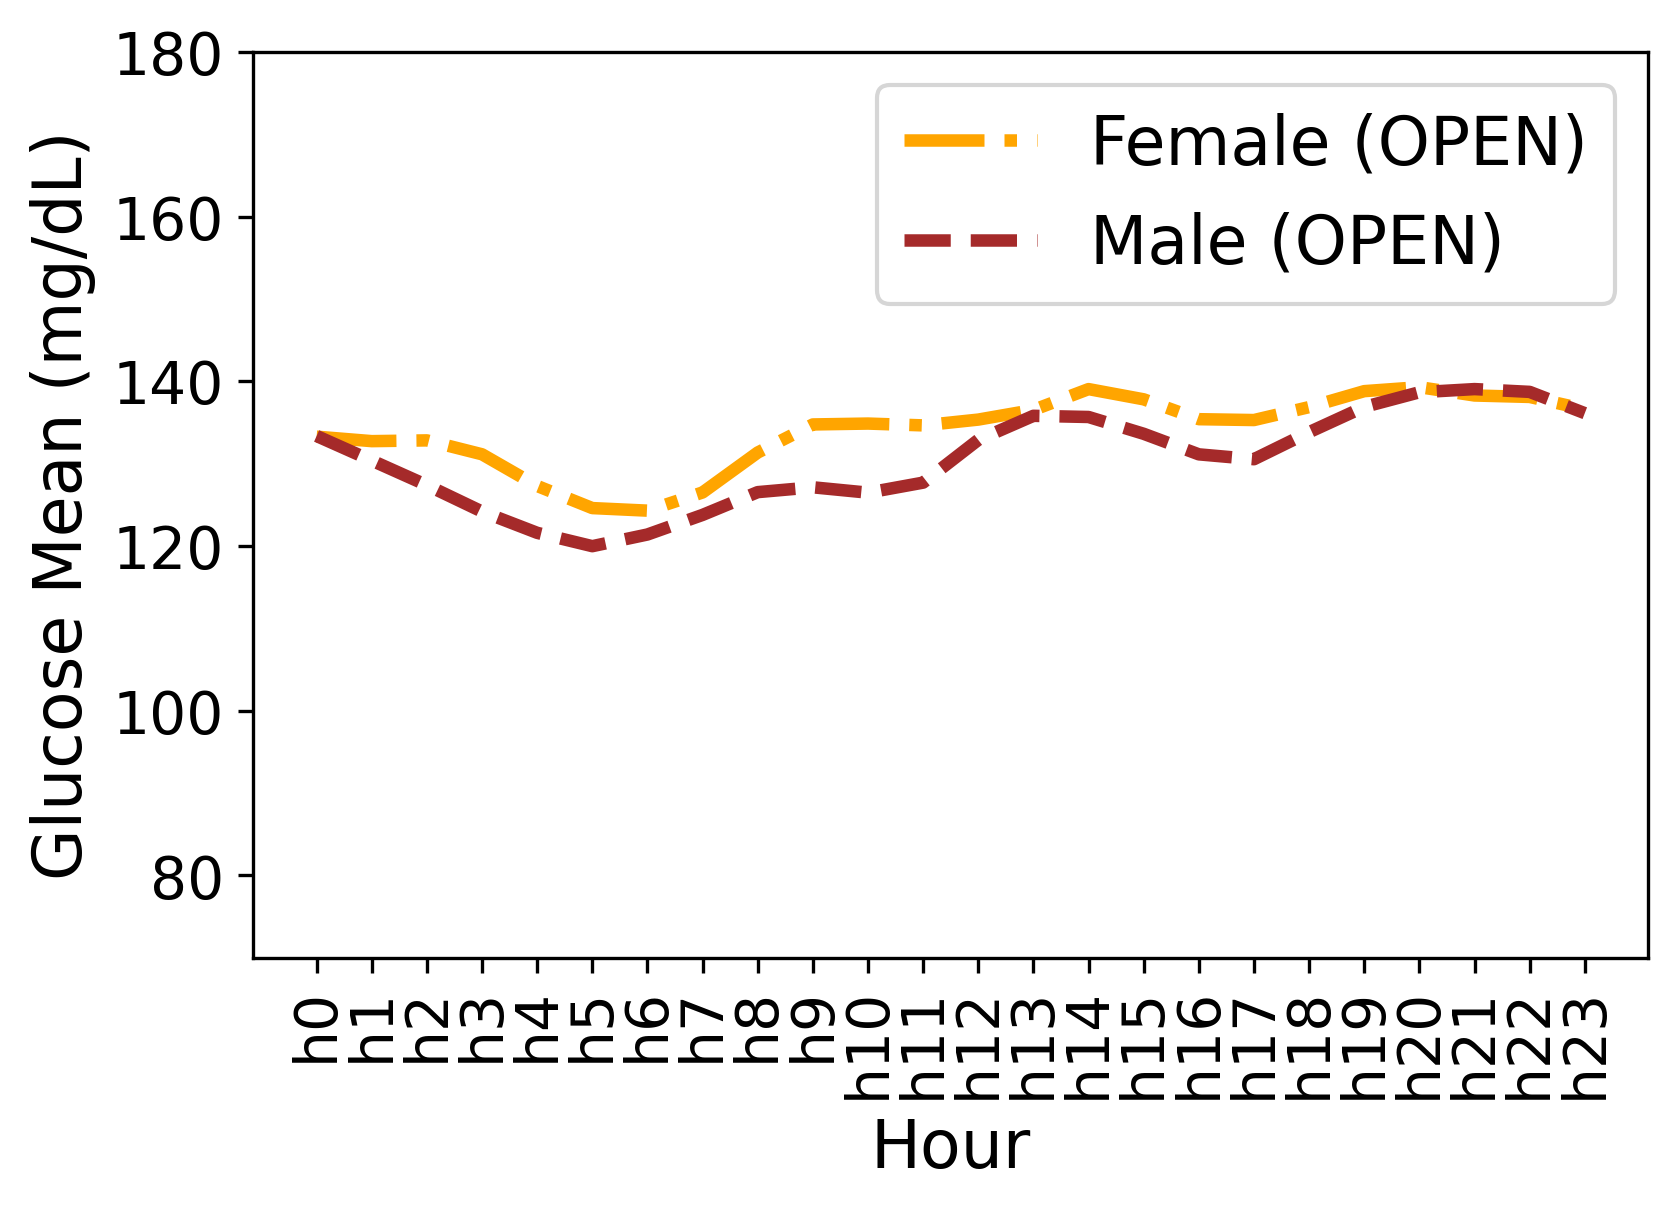

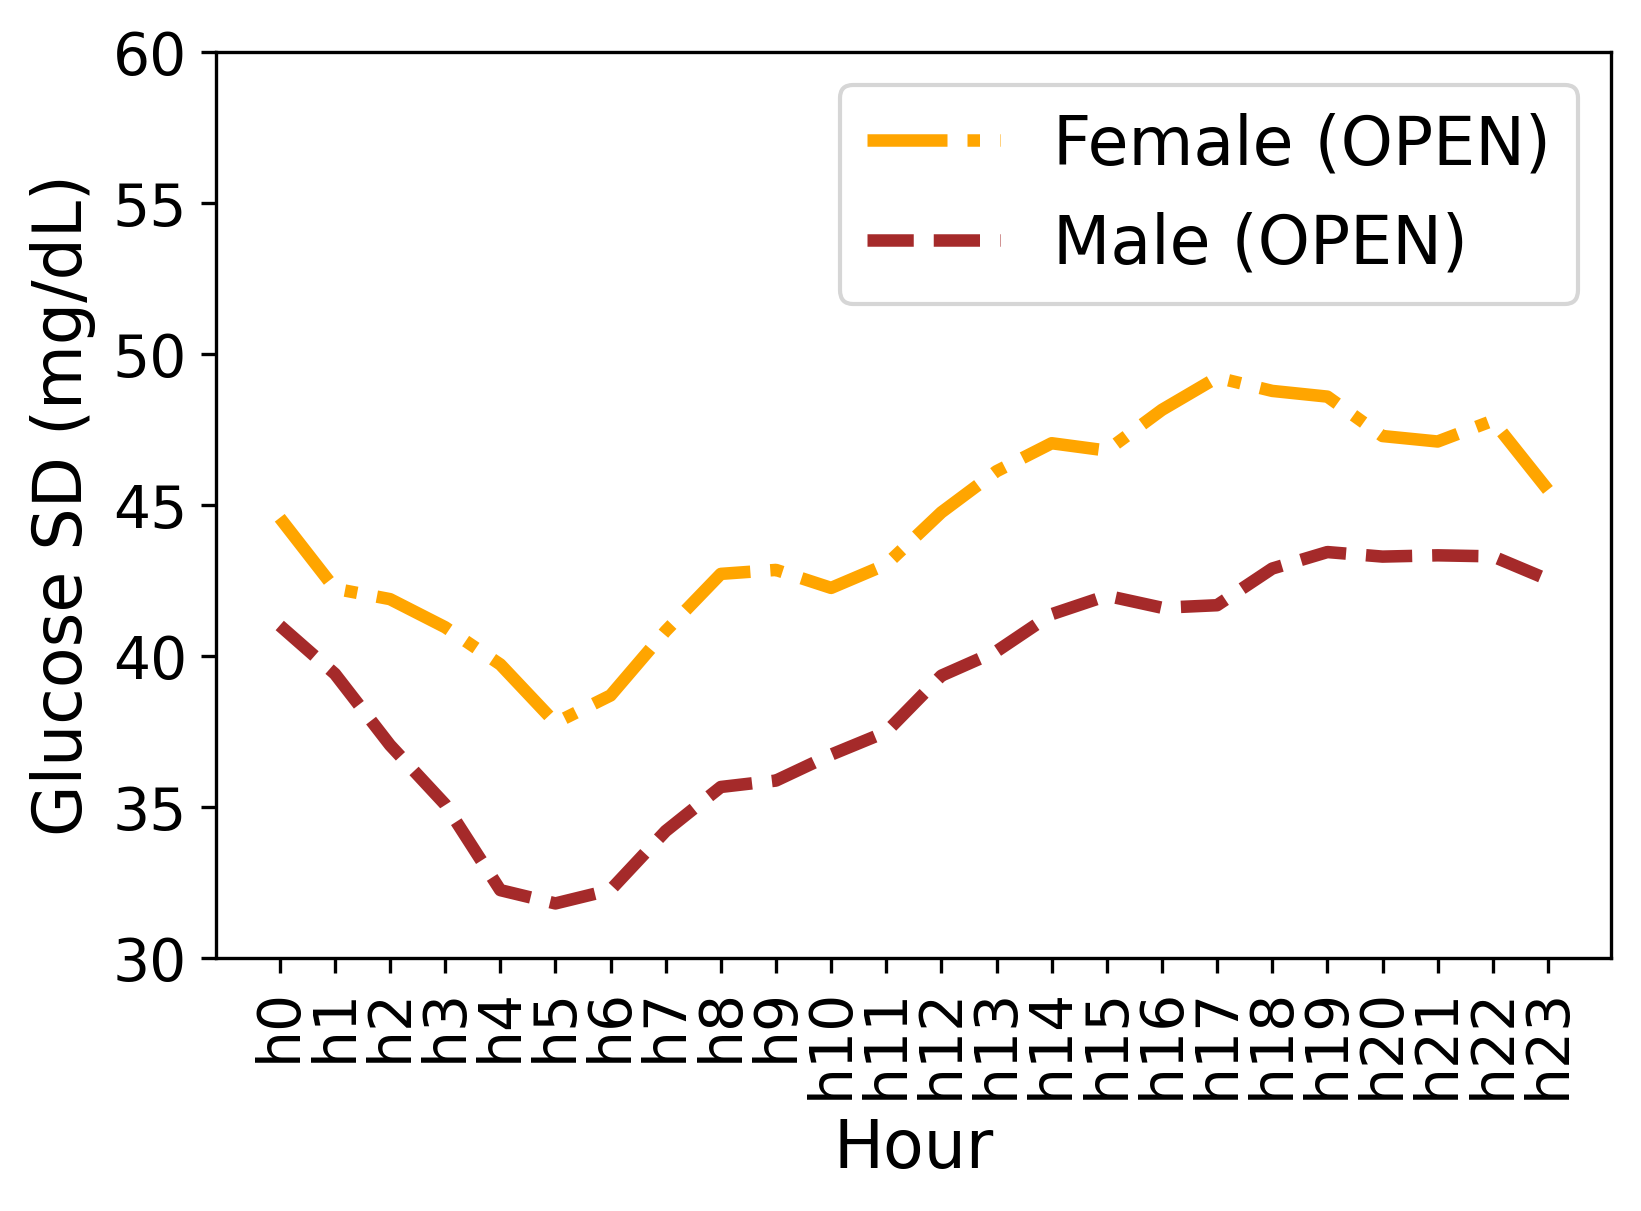

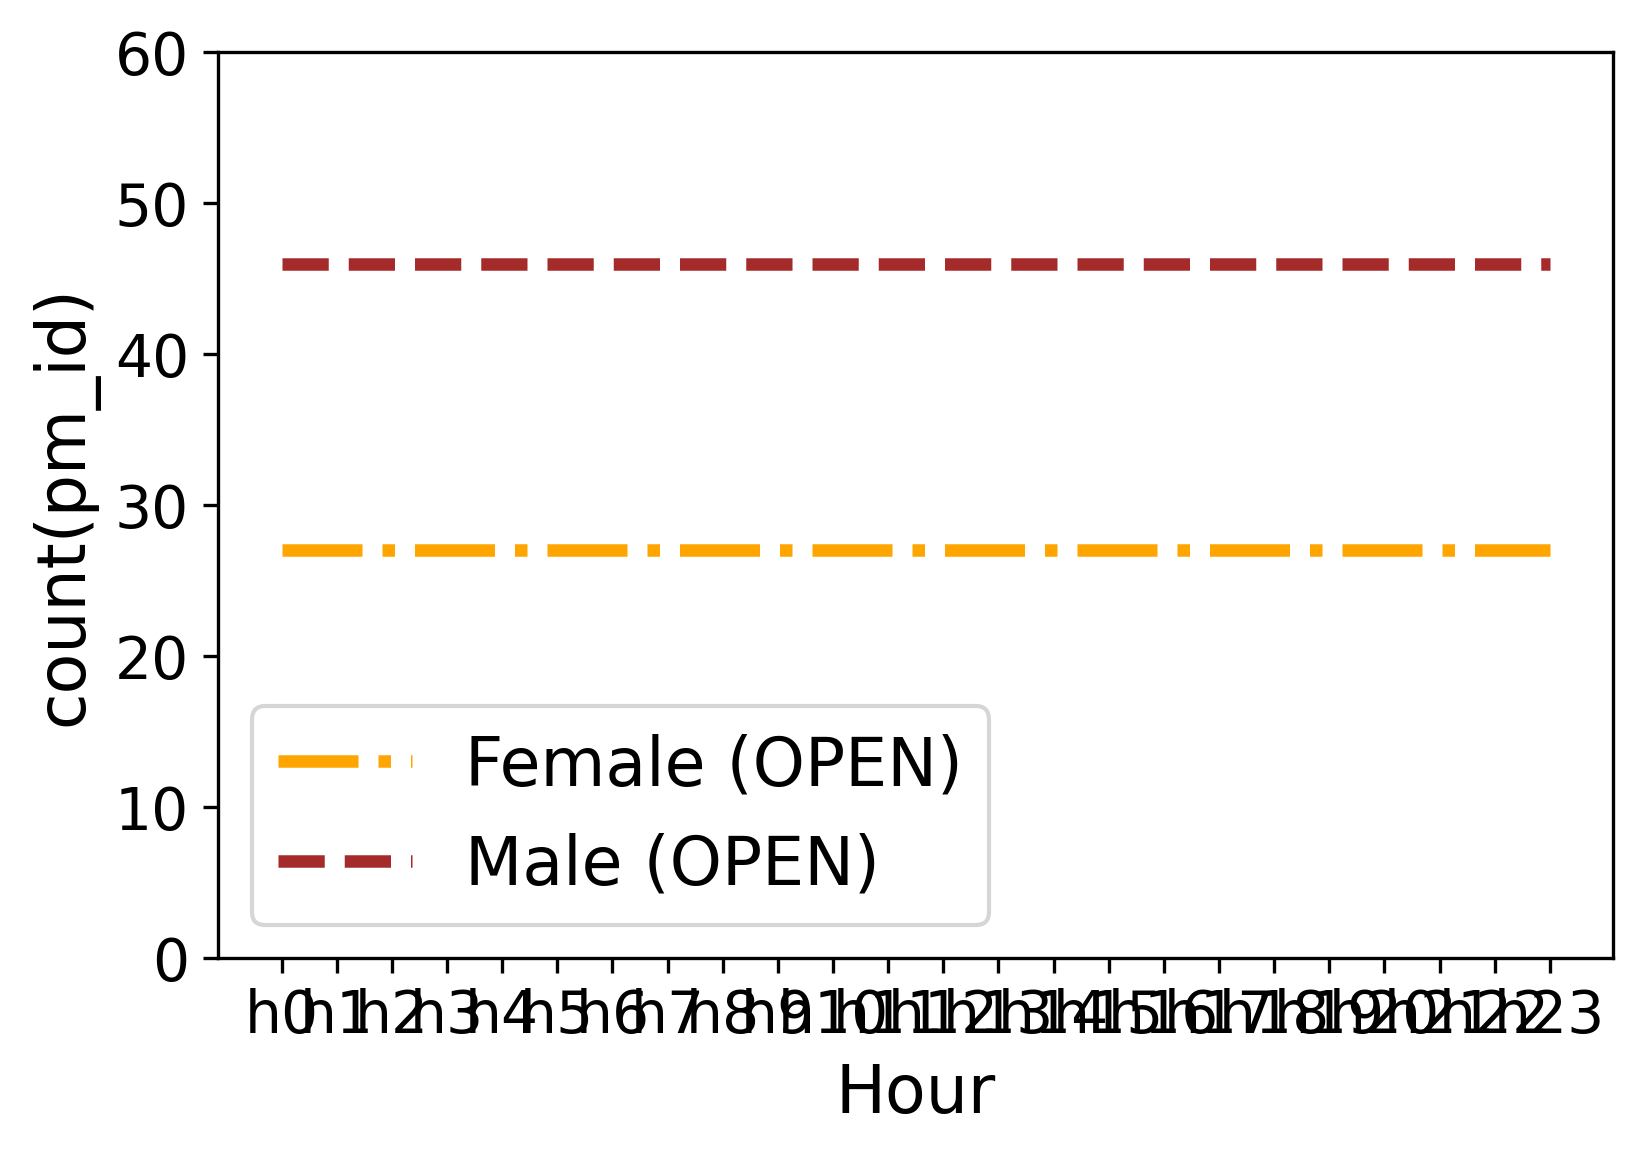

In [8]:

sorter = [
    'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
    'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
    'h22', 'h23'
]
var = "hour"
path = f"/home/reinhold/Daten/Paper_Datasets_Nov2022/results/{var}ly_OPENonOH"

plot(var, "Hour", sorter, path)
#plot2(var, "Hour", sorter, path)
plt.show()


# Average Statistics based on Monthly Breakdown 

OPENonOH: mean
female mean min:  126.88090473157054 m2
female mean mean:  130.9811967126509
female mean max:  135.98932081102038 m8
male mean min:  128.1914499177433 m6
male mean mean:  130.8947905425106
male mean max:  133.485753274401 m12
OPENonOH: std
female std min:  42.98831696706617 m3
female std mean:  45.39825379925318
female_std max:  49.04714535952217 m8
male std min:  39.14350195969624 m3
male std mean:  40.66140484564395
male std max:  42.20616705525577 m8


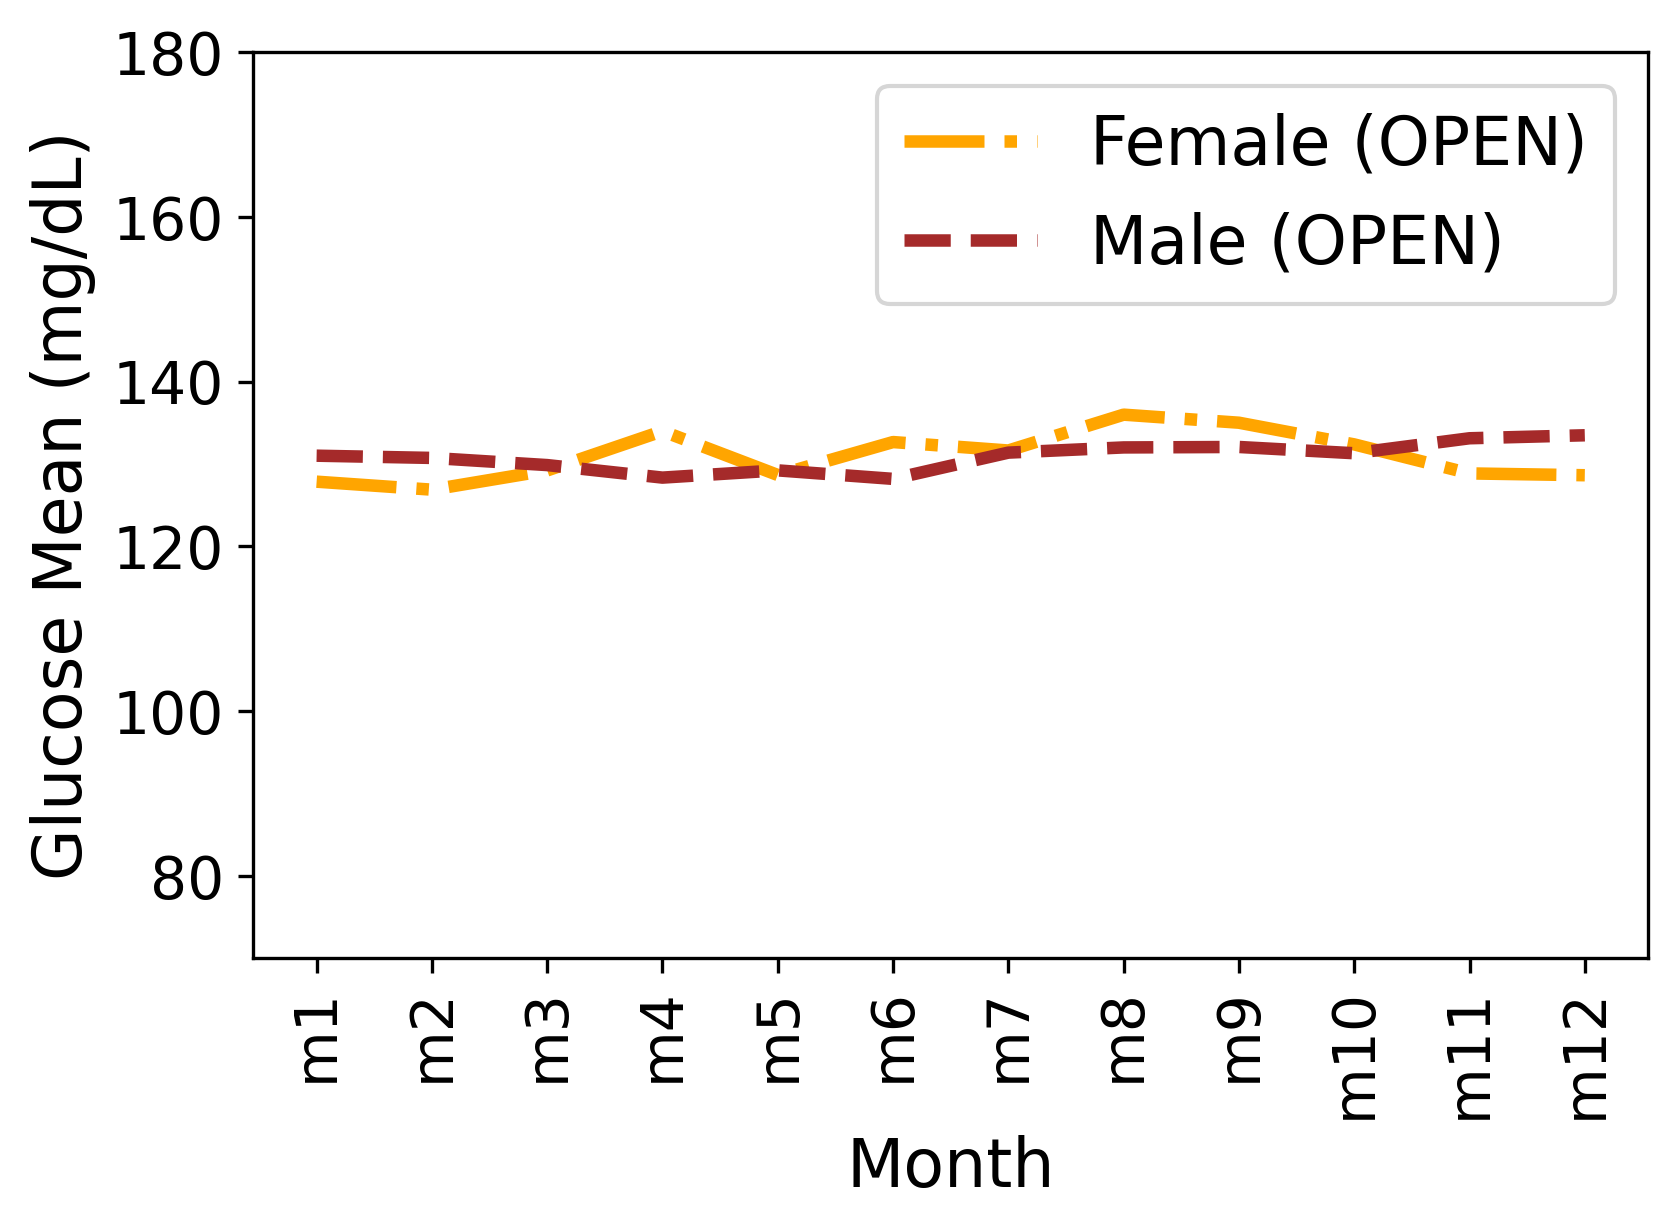

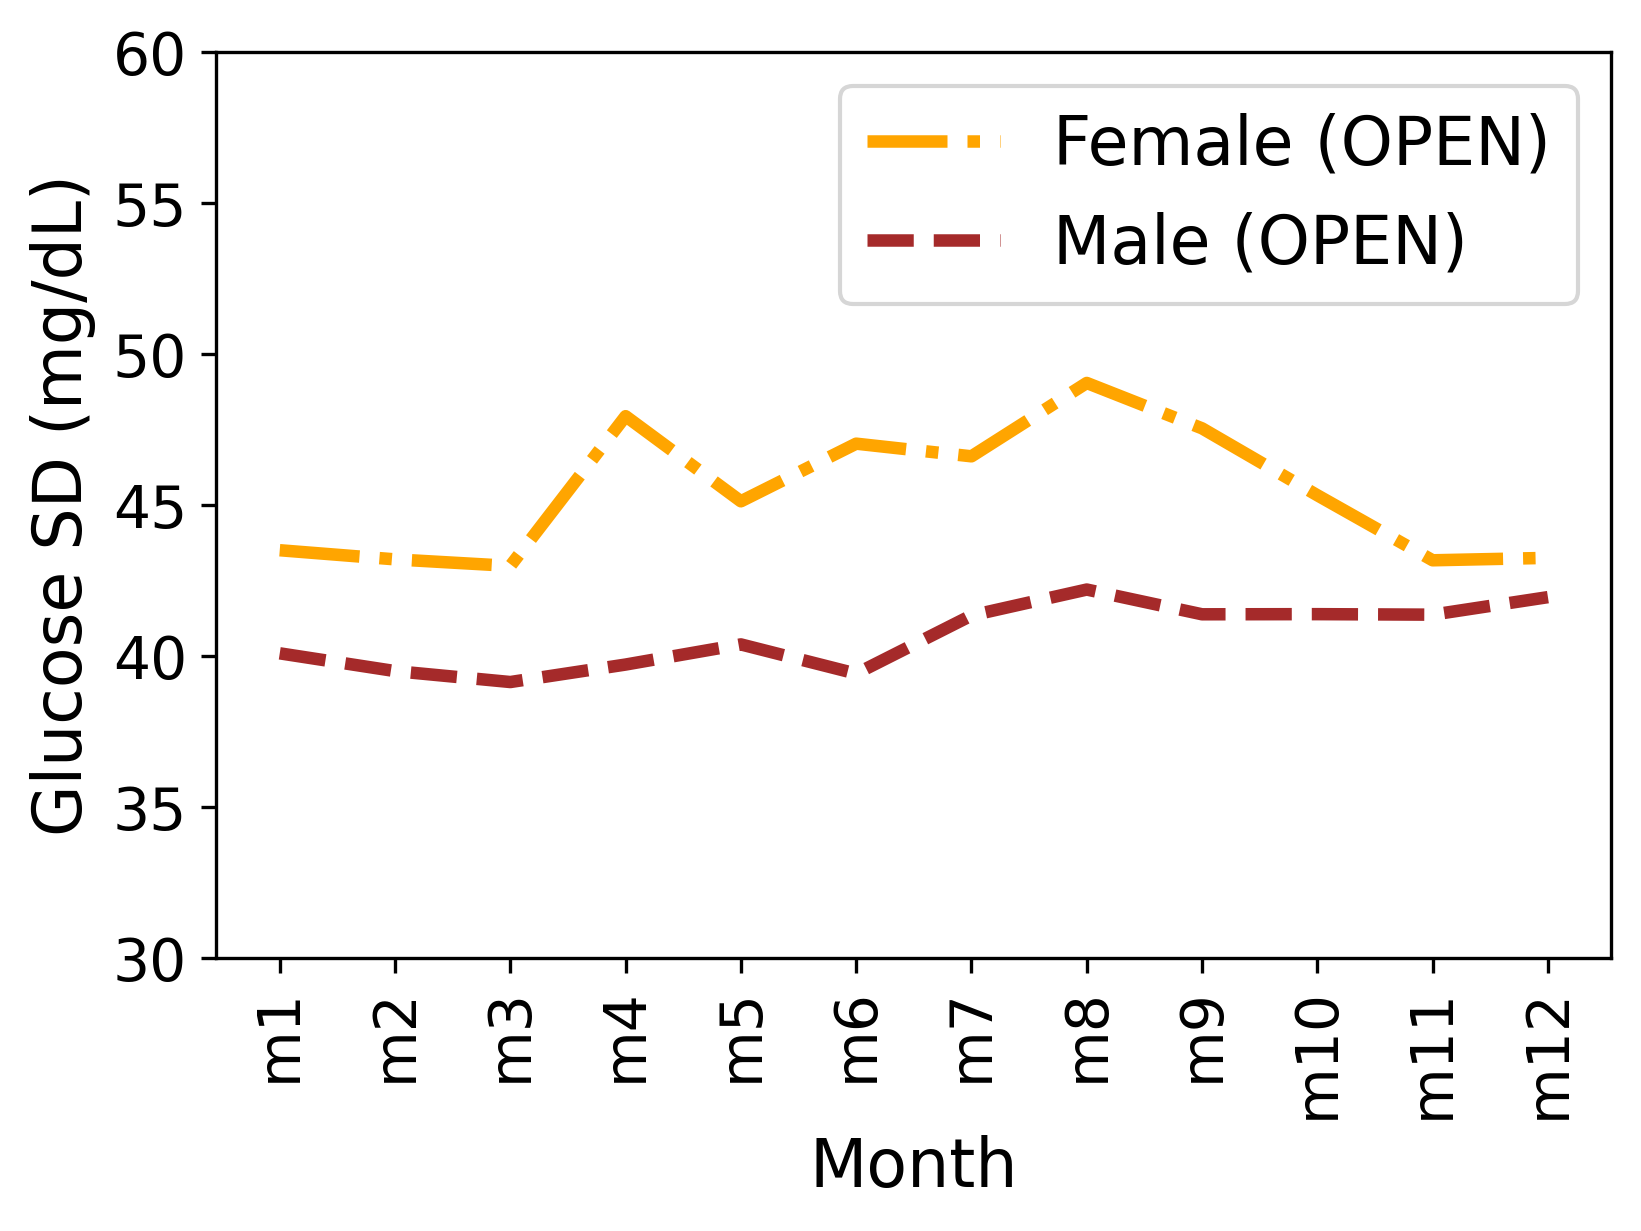

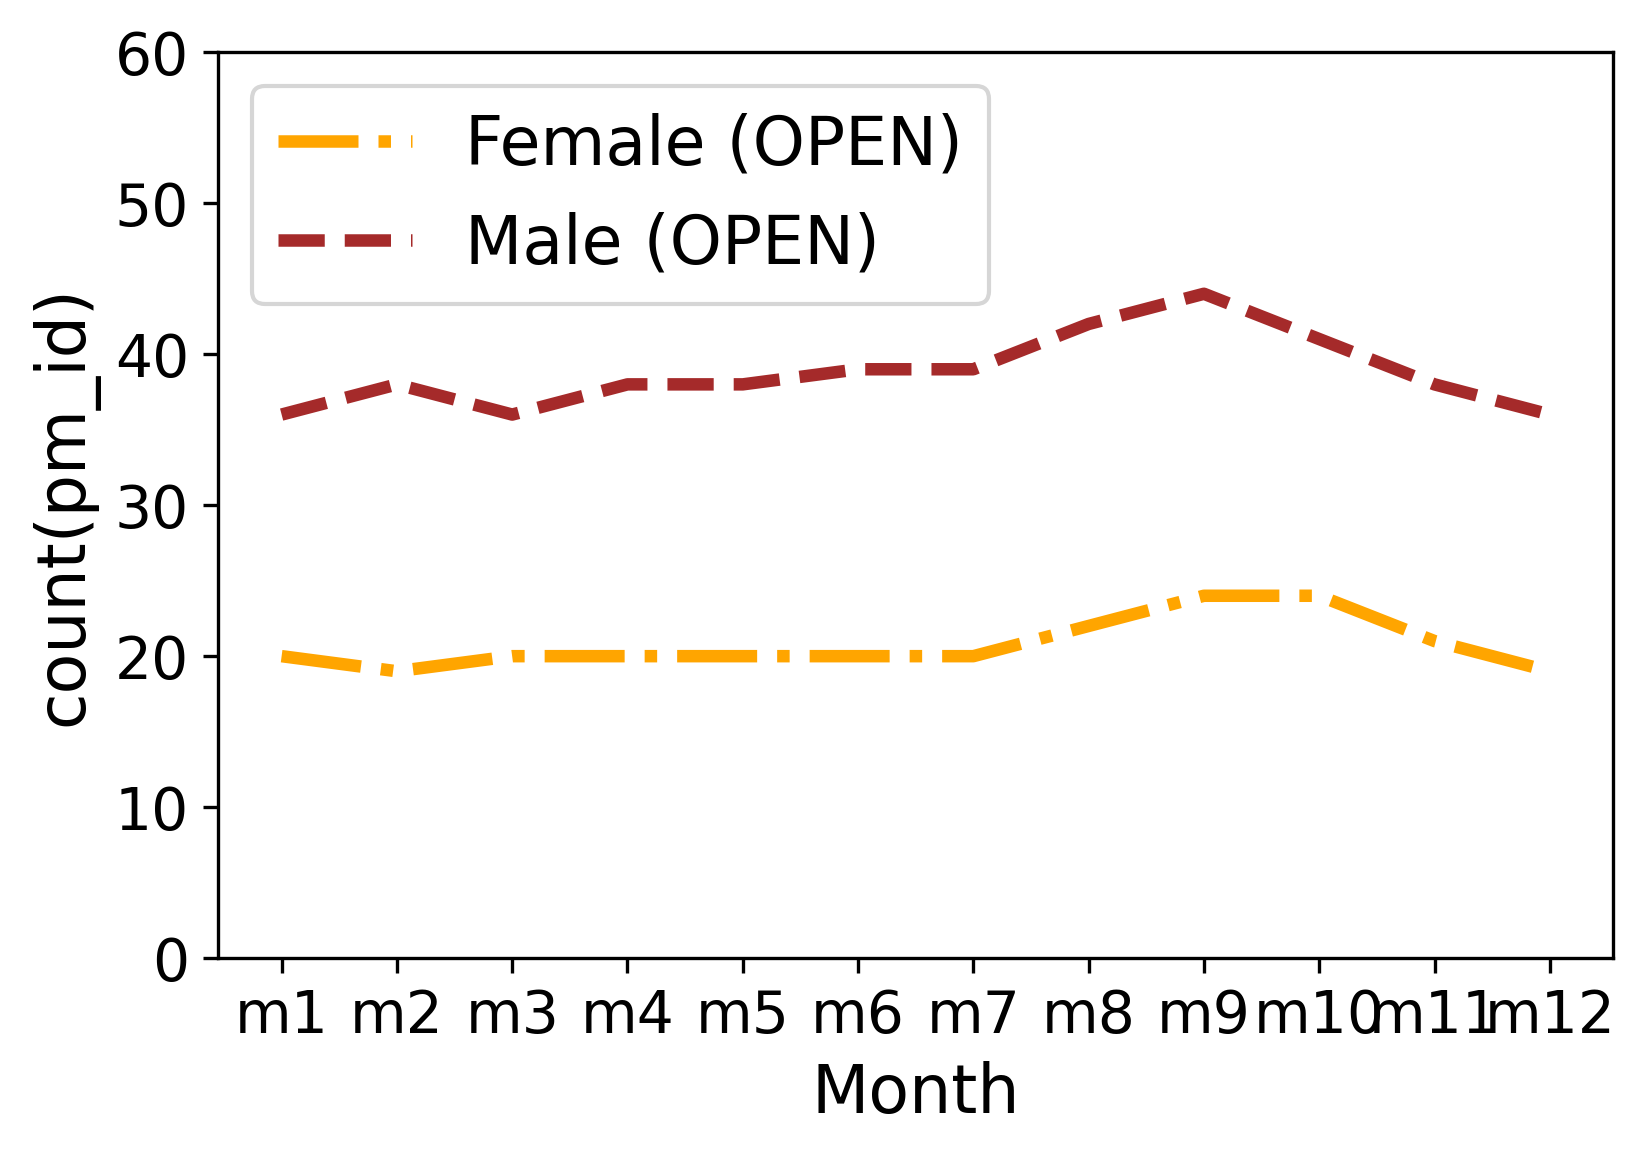

In [9]:
sorter = [
    'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
]
var = "month"
var_label = "Month"
path = f"/home/reinhold/Daten/Paper_Datasets_Nov2022/results/{var}ly_OPENonOH"

plot(var, var_label, sorter, path)
#plot2(var, var_label, sorter, path)
plt.show()

OPENonOH: mean
female mean min:  129.5885232733495 d26
female mean mean:  133.9615401911474
female mean max:  138.02112957803953 d25
male mean min:  128.48653816114972 d6
male mean mean:  130.5539922041818
male mean max:  132.3926563300991 d4
OPENonOH: std
female std min:  41.873041072358546 d26
female std mean:  46.1932173510464
female_std max:  49.36003852499493 d14
male std min:  39.1007319412049 d6
male std mean:  40.39701325154236
male std max:  42.040979564519944 d24


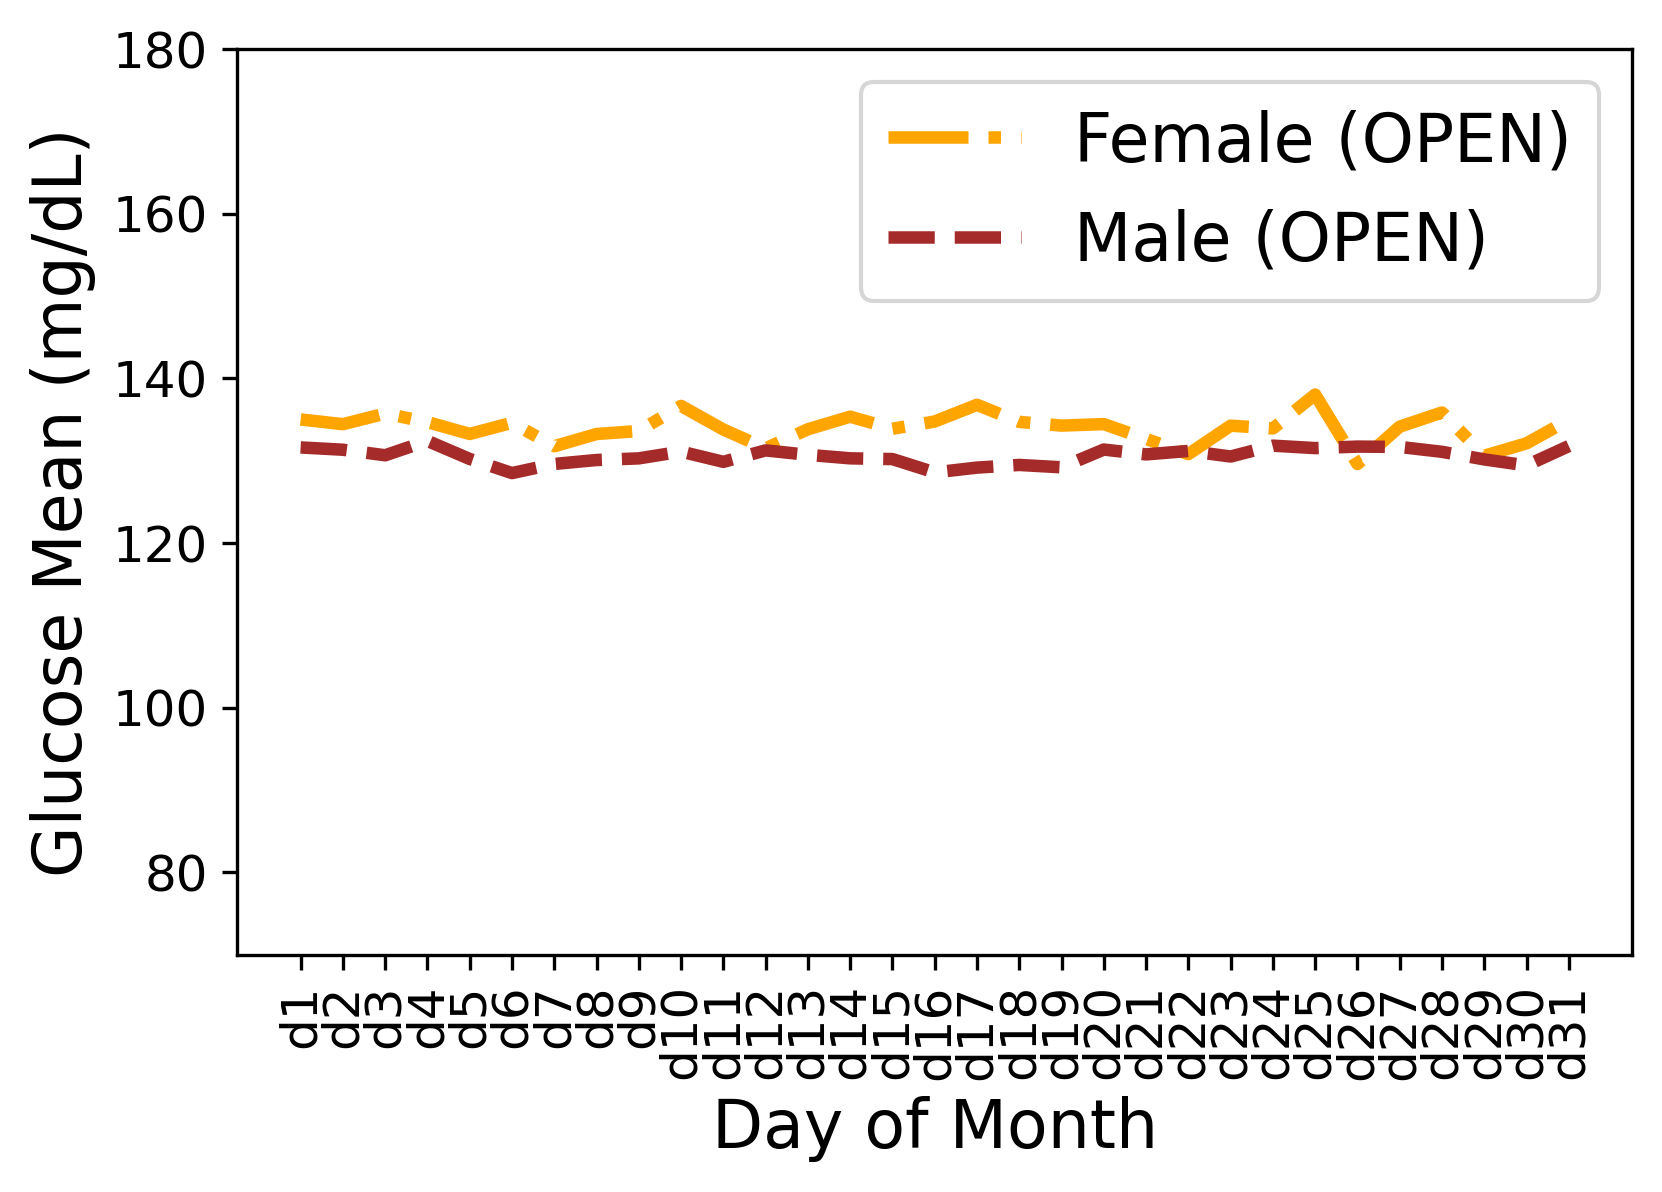

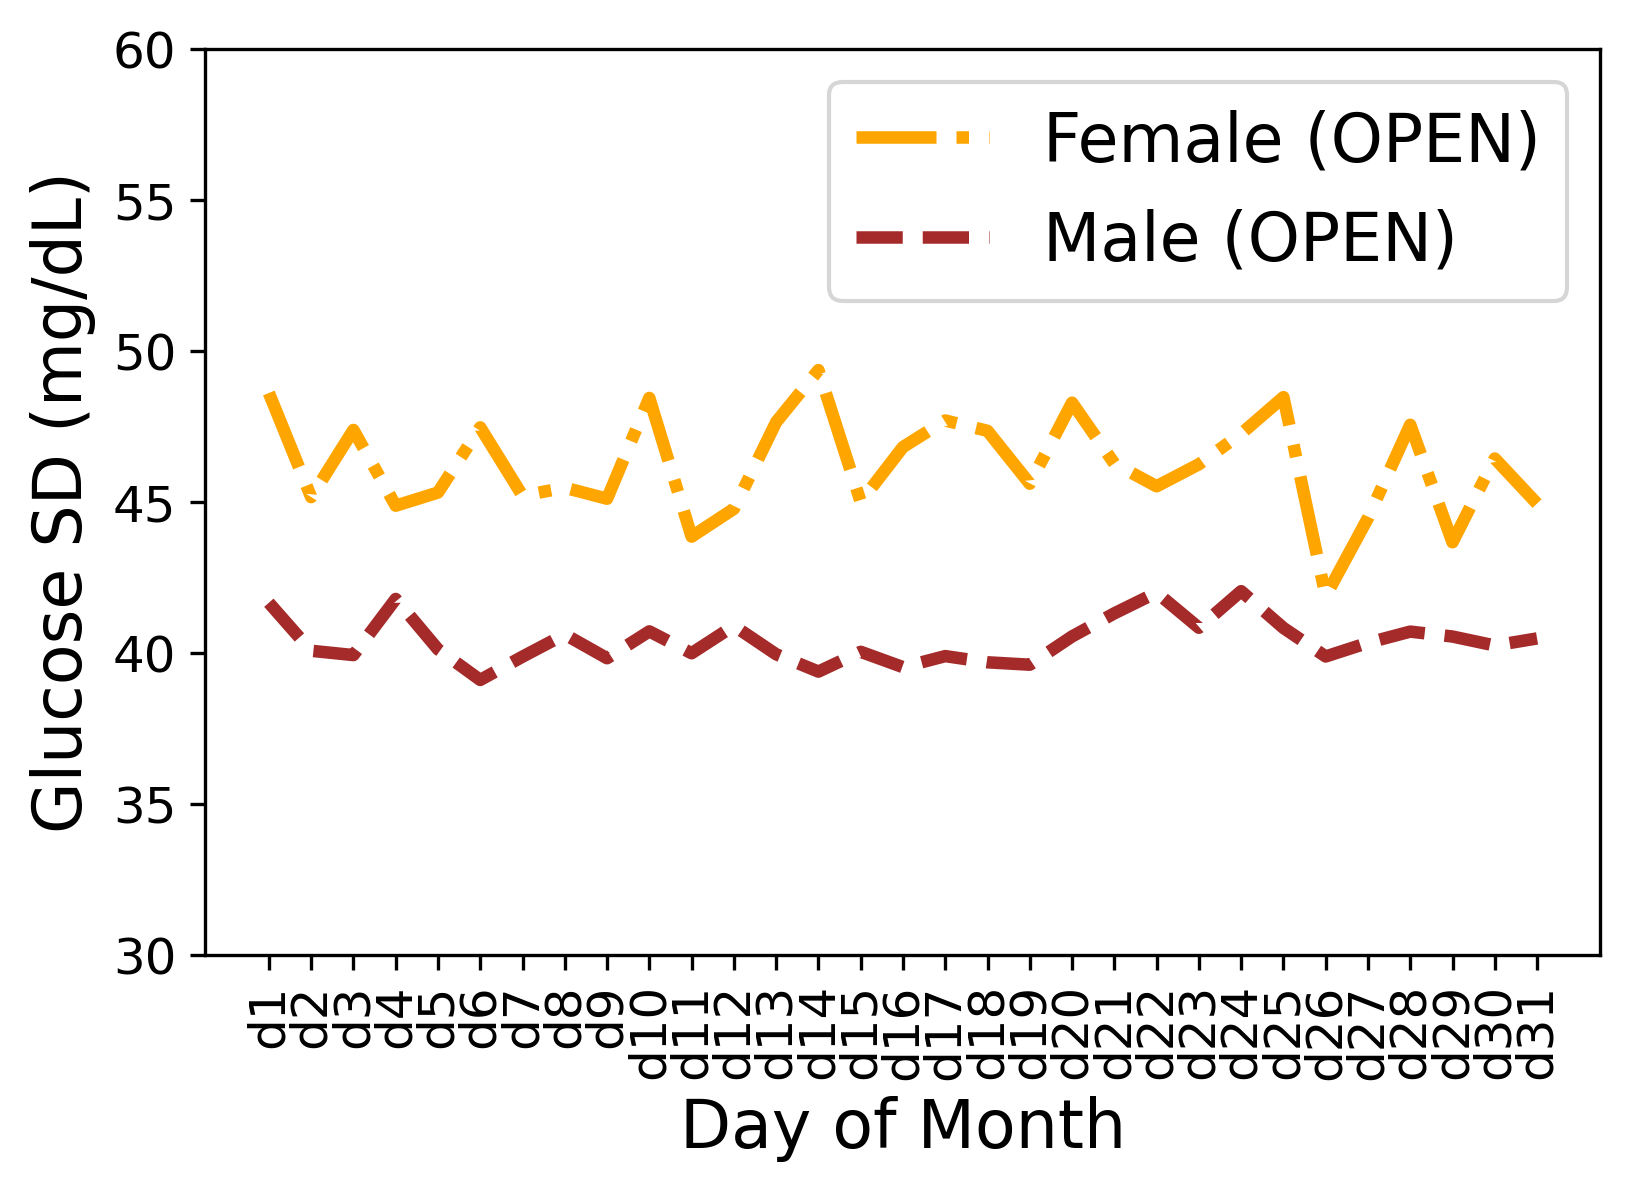

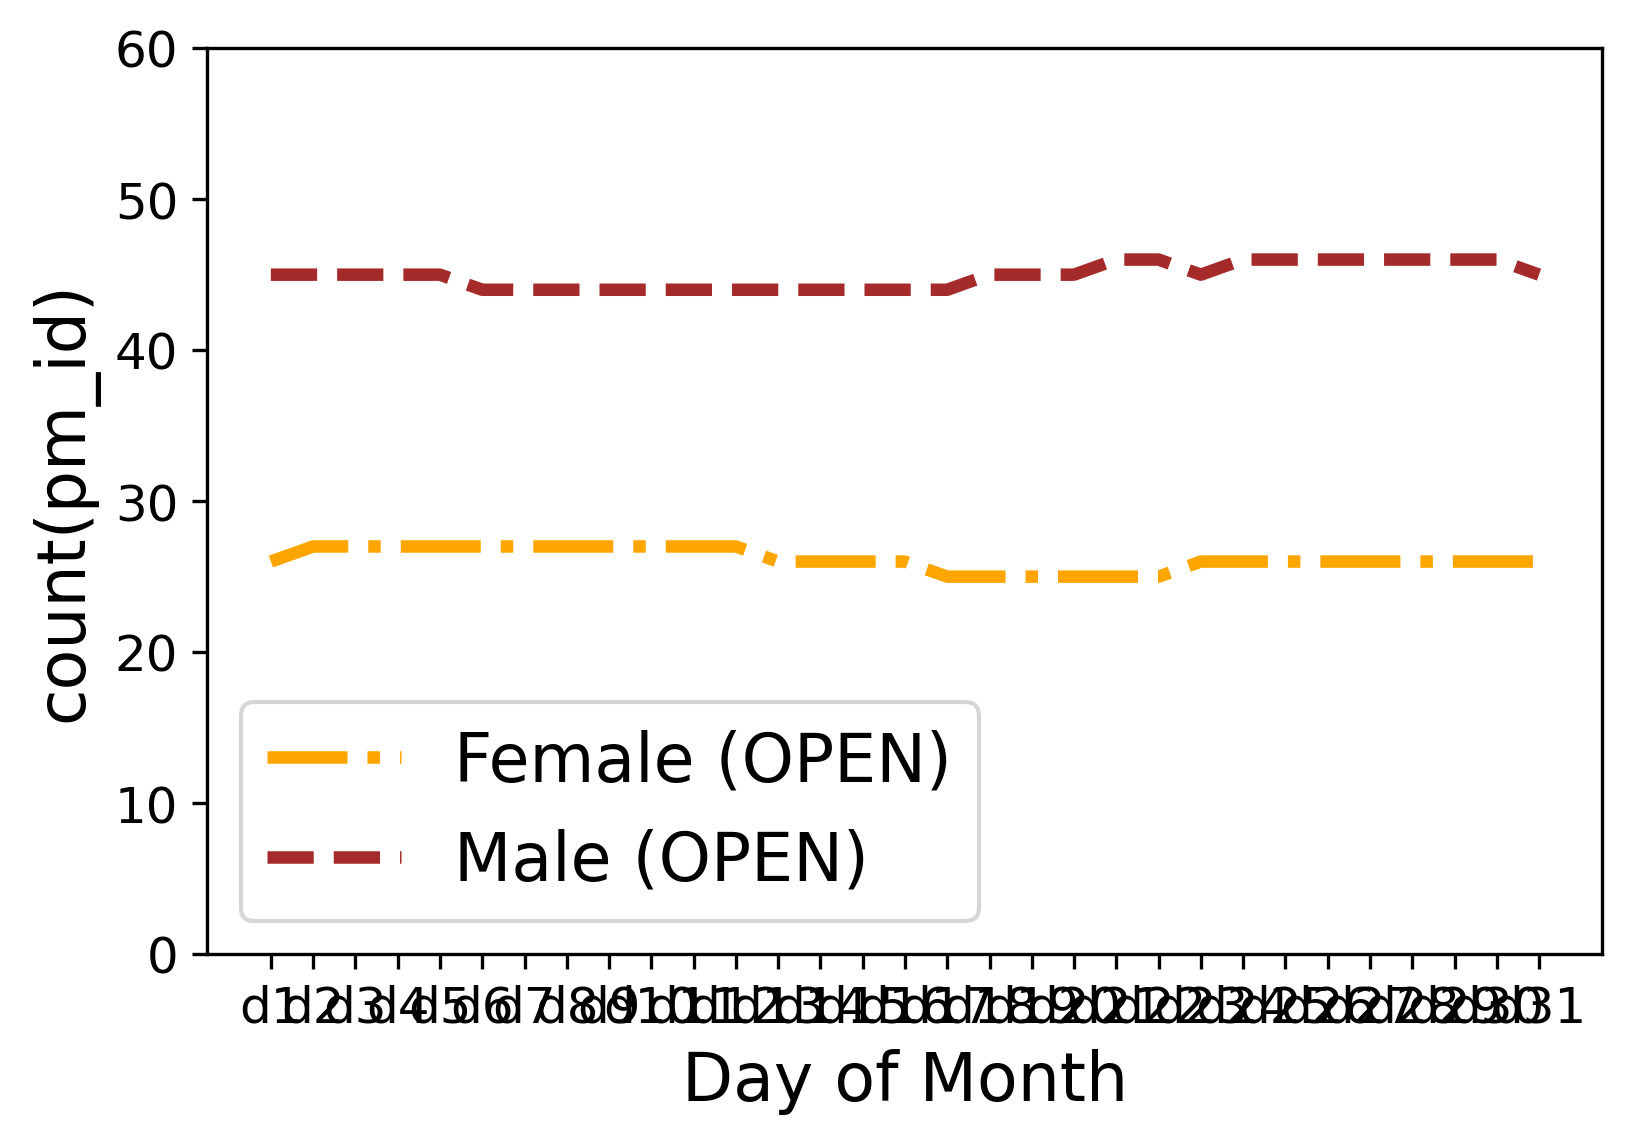

In [10]:
sorter = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12',
    'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22',
    'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31'
]

var = "day"
path = f"/home/reinhold/Daten/Paper_Datasets_Nov2022/results/{var}ly_OPENonOH"

plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})
plot(var, "Day of Month", sorter, path)
plt.show()
#plot2(var, "Day of Month", sorter, path)


OPENonOH: mean
female mean min:  132.09971390915527 Monday
female mean mean:  133.8837382511668
female mean max:  135.61622466798696 Tuesday
male mean min:  128.92587213701472 Thursday
male mean mean:  130.5101595196427
male mean max:  132.31075287448533 Sunday
OPENonOH: std
female std min:  45.567131909383775 Monday
female std mean:  46.850513721299215
female_std max:  47.94937223149599 Sunday
male std min:  39.86378667696381 Tuesday
male std mean:  40.87679751915216
male std max:  42.79470855242589 Saturday


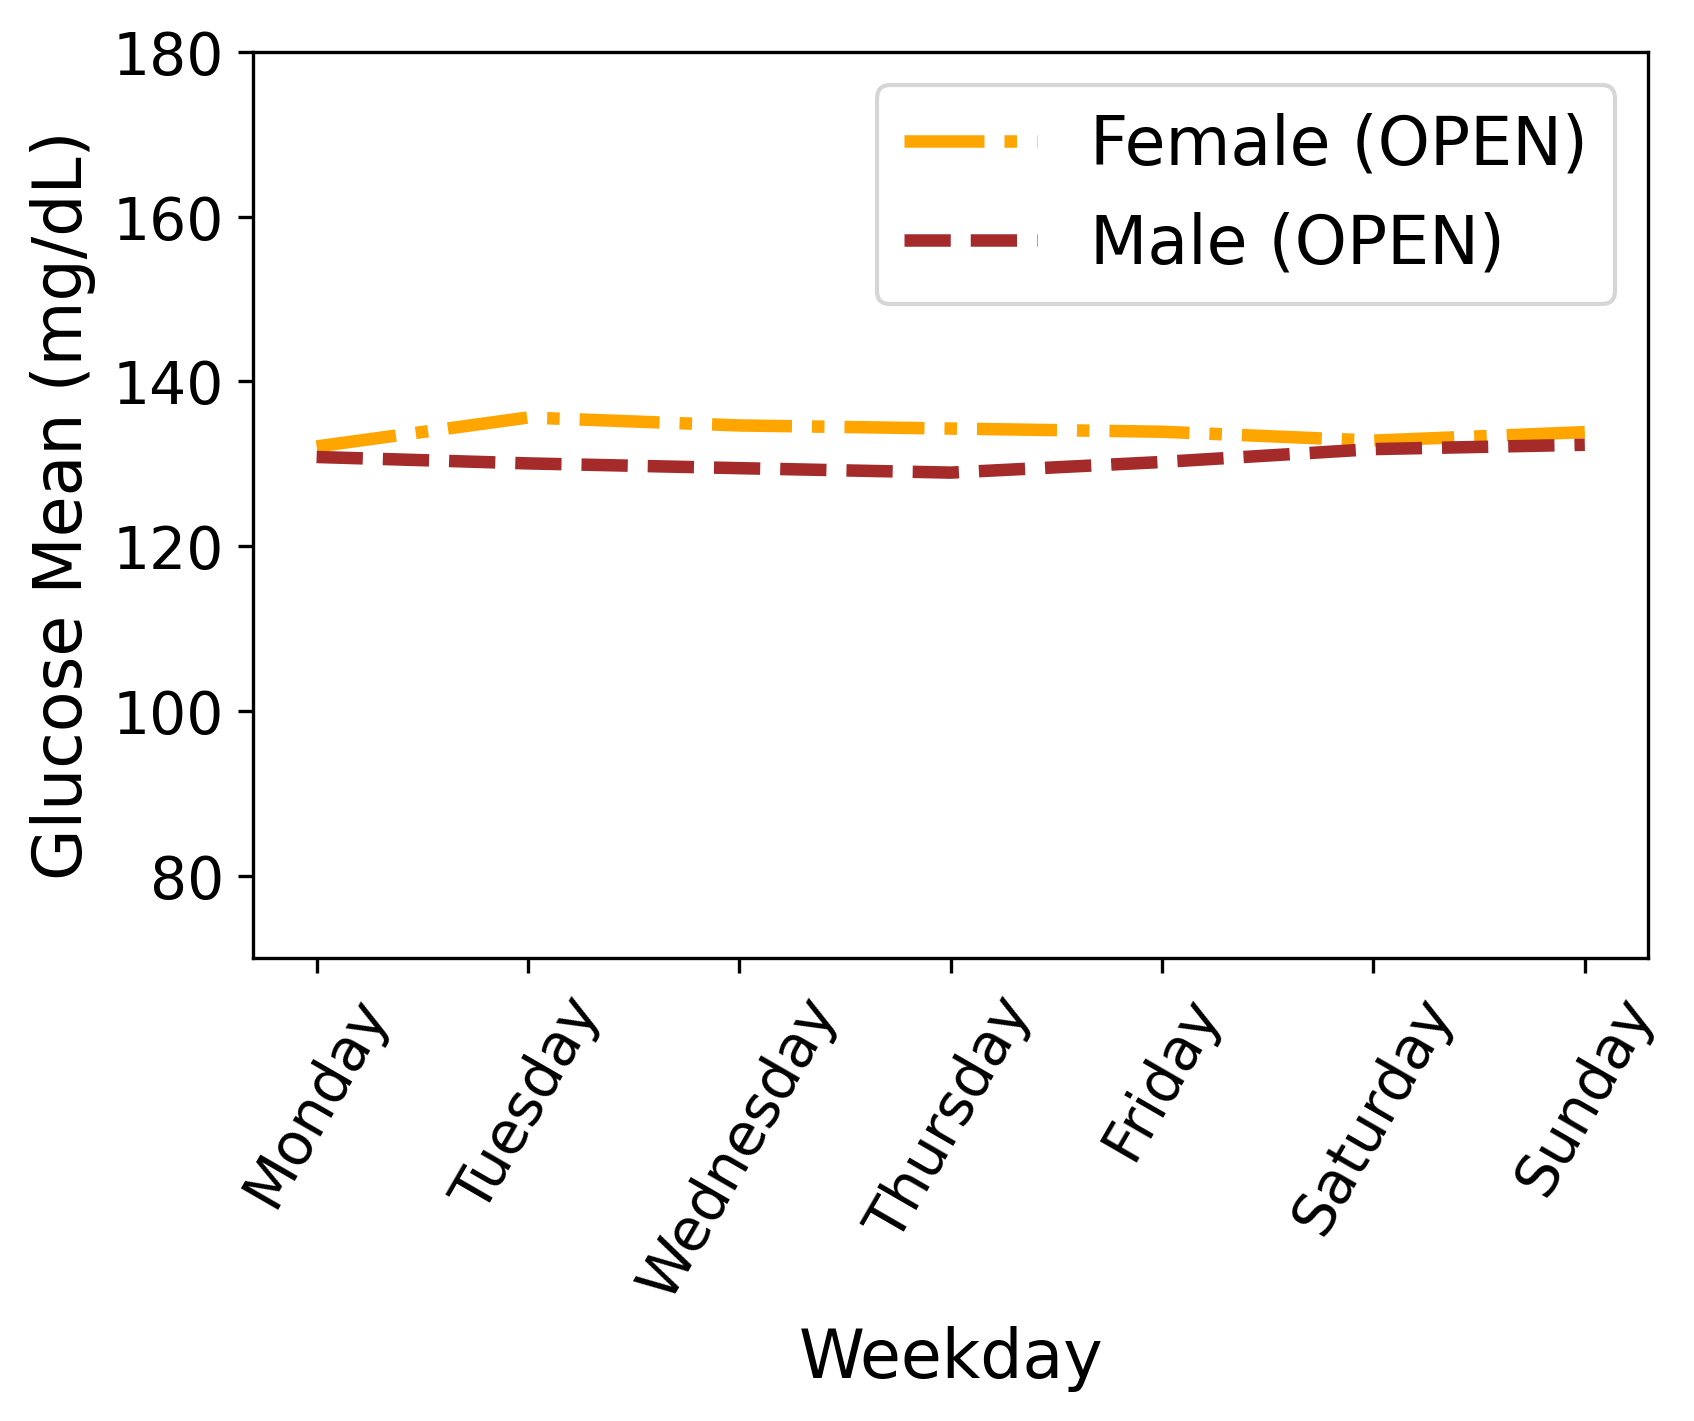

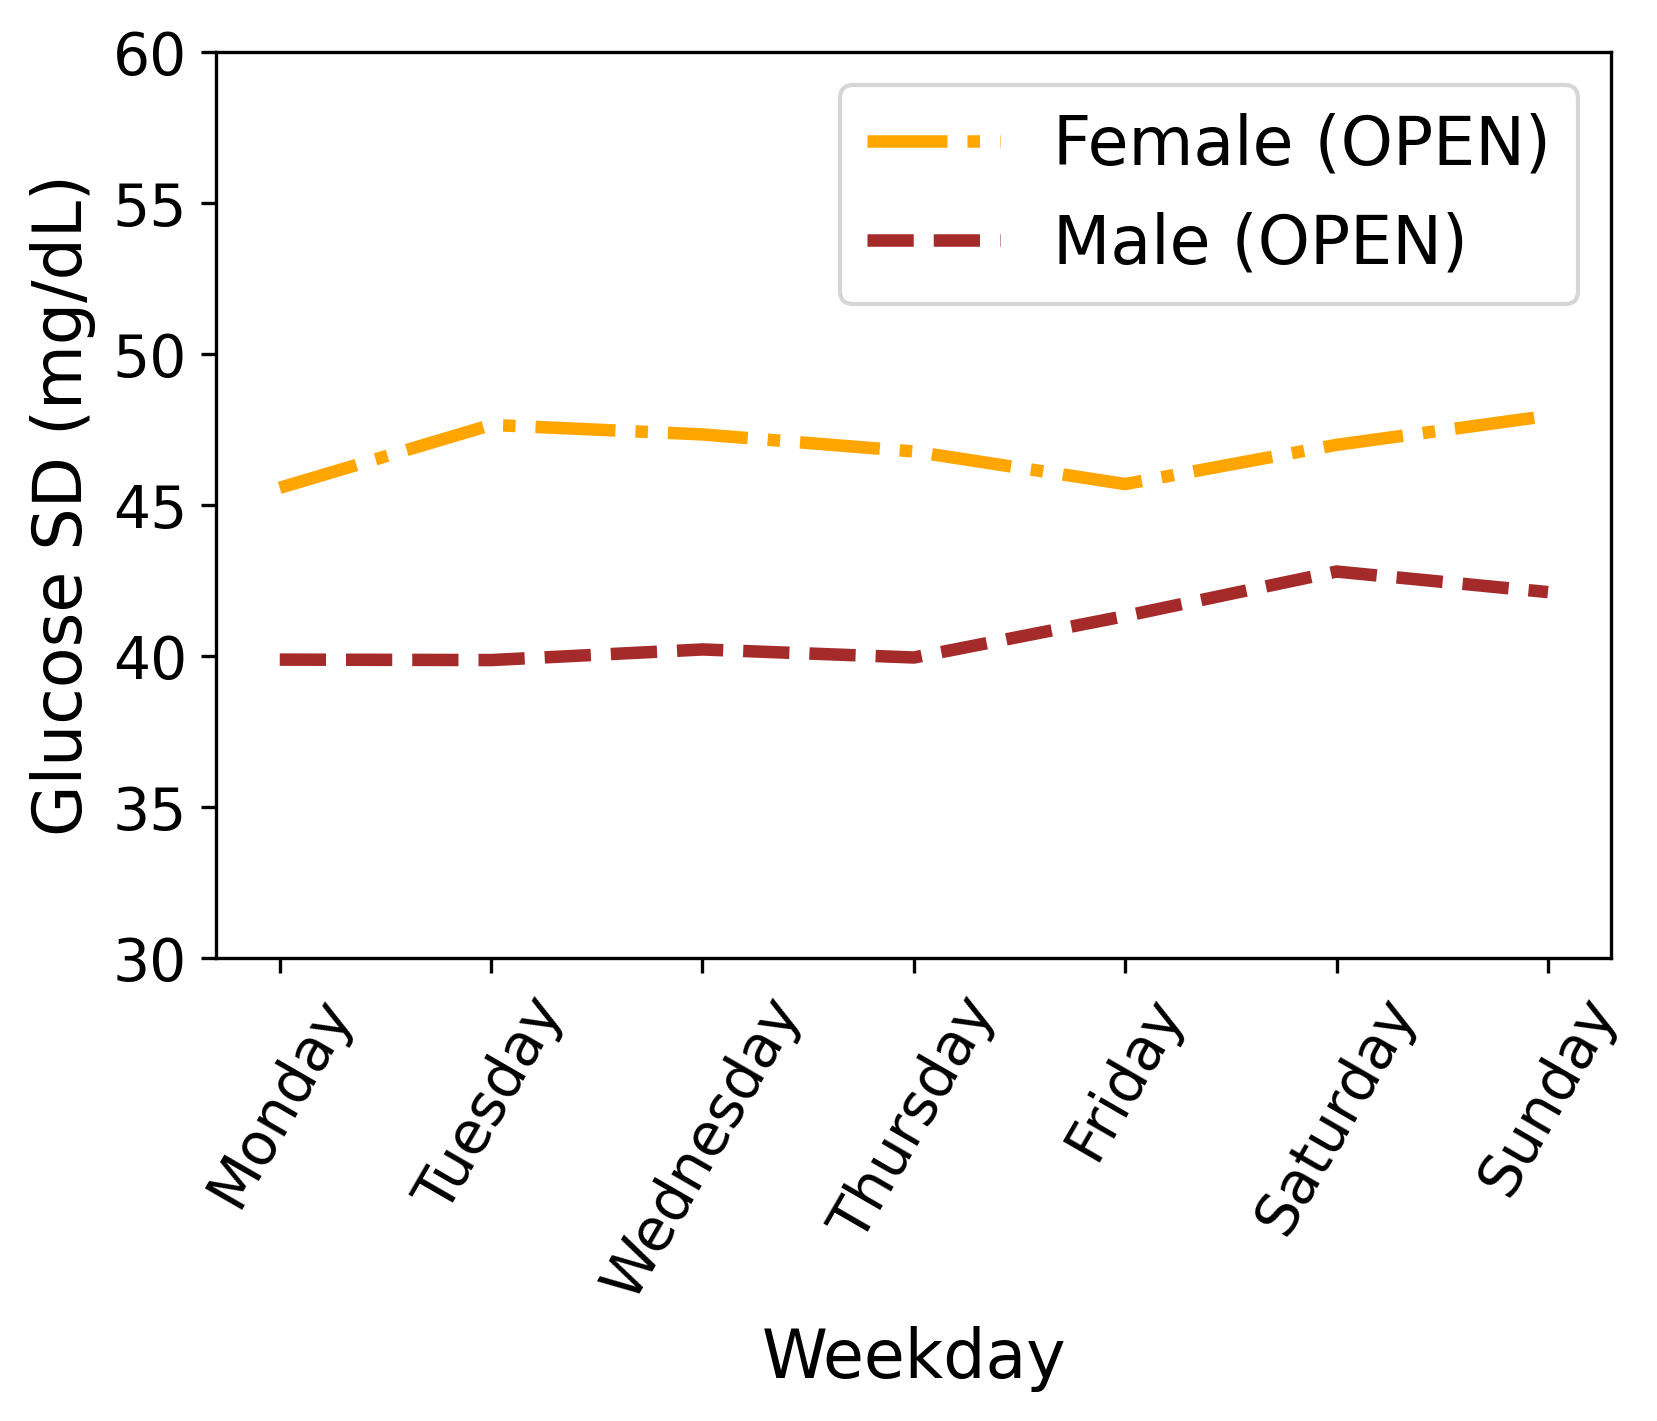

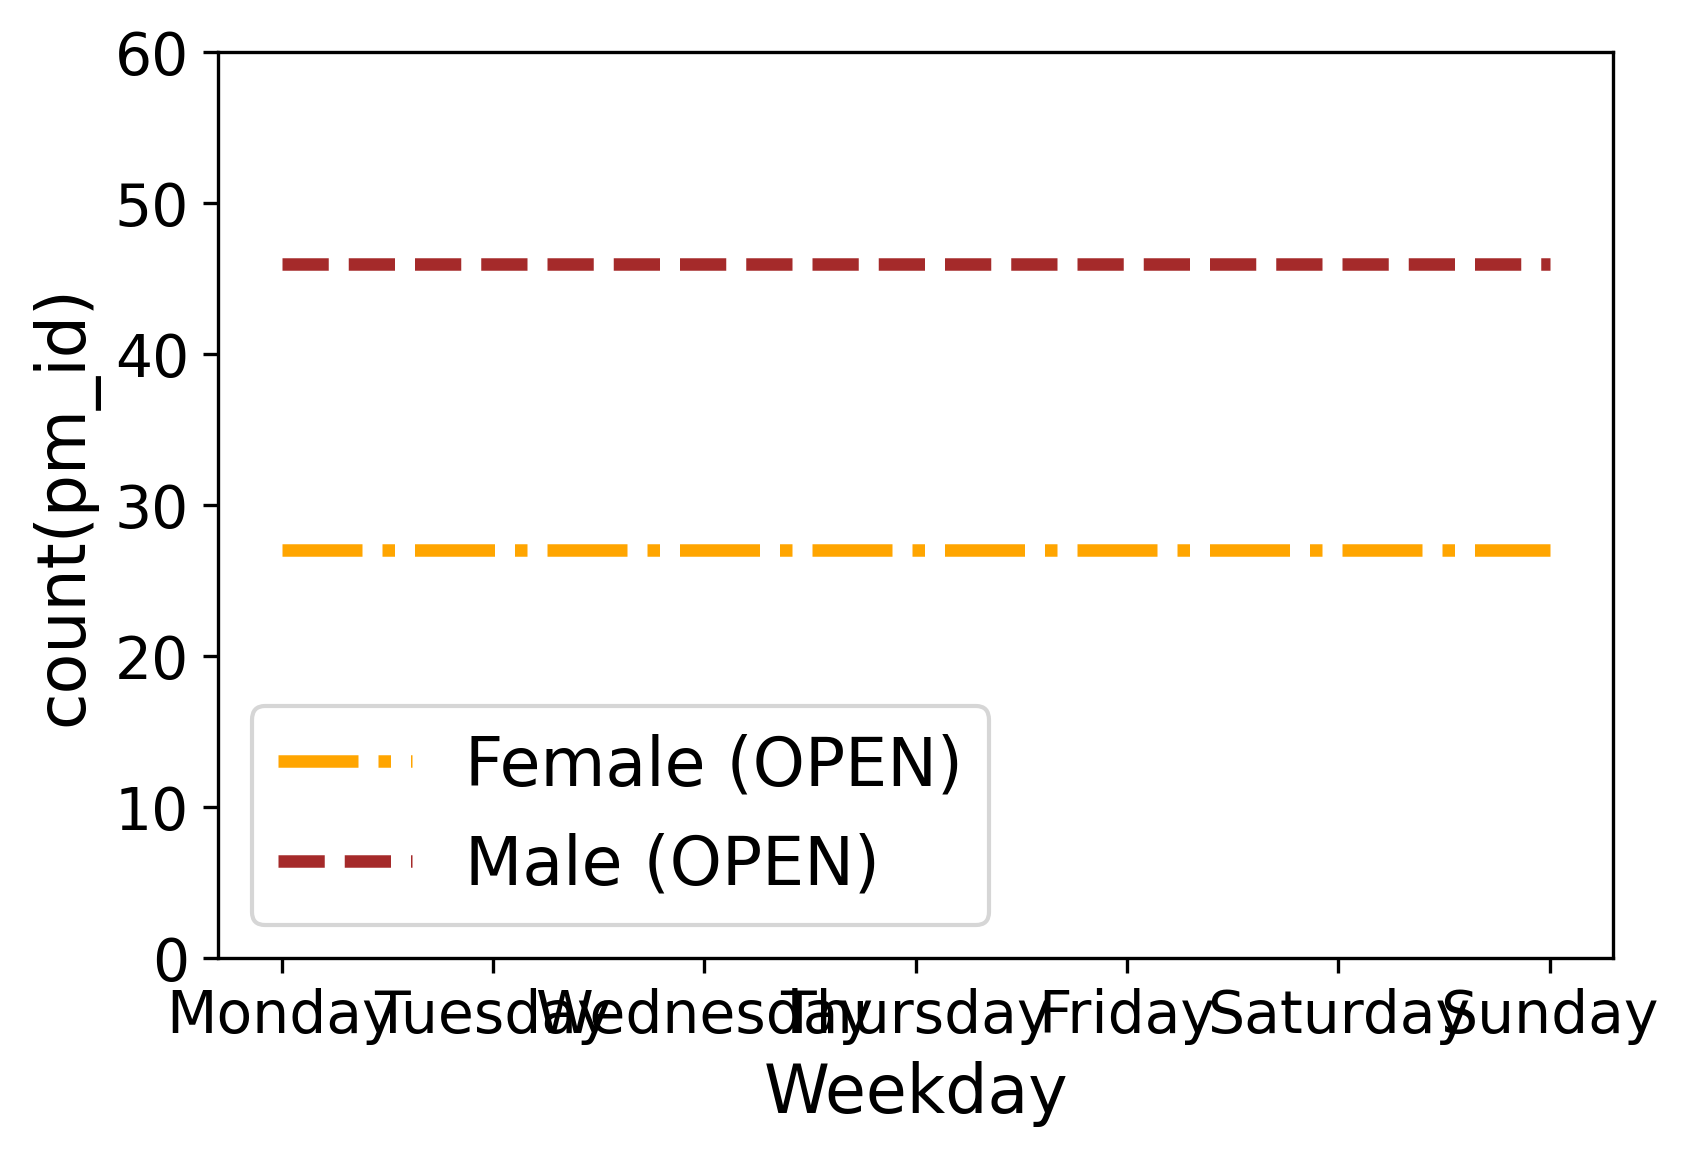

In [11]:
sorter = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]

var = "DoW"
path = f"/home/reinhold/Daten/Paper_Datasets_Nov2022/results/{var}ly_OPENonOH"
plt.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14})
plot(var, "Weekday", sorter, path)
plt.show()
#plot2(var, "Weekday", sorter, path)